In [1]:
from __future__ import absolute_import, unicode_literals, print_function
import itertools as it
import logging
import warnings

import matplotlib as mpl
import matplotlib.collections
import matplotlib.patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import path_helpers as ph
import pint
import svg_model

# Prevent `RuntimeWarning` messages from printing due to `np.nan` values in
# `get_intersections()` comparisons.
# warnings.filterwarnings("ignore", category=RuntimeWarning)

ureg = pint.UnitRegistry()

%matplotlib notebook

In [2]:
def get_segments(df_shapes, distance_threshold=0.1 * ureg.mm):
    distance_threshold_px = (distance_threshold * 96 *
                             ureg.pixels_per_inch).to('pixels')
    df_segments = (df_shapes.groupby('id').apply(lambda x: x.iloc[:-1])
                   .reset_index(drop=True)
                   .join(df_shapes.groupby('id').apply(lambda x: x.iloc[1:])
                         .reset_index(drop=True),
                         rsuffix='2'))[['id', 'vertex_i', 'vertex_i2',
                                        'x', 'y', 'x2', 'y2']]
    v = (df_segments[['x2', 'y2']].values - df_segments[['x', 'y']]).values
    mid = .5 * v + df_segments[['x', 'y']].values
    x_mid = mid[:, 0]
    y_mid = mid[:, 1]
    length = np.sqrt((v ** 2).sum(axis=1))
    v_scaled = distance_threshold_px.magnitude * v / length[:, None]
    x_normal = -v_scaled[:, 1]
    y_normal = v_scaled[:, 0]

    # Create new data frame from scratch and join it to the `df_segments`
    # frame since it is **much** faster than adding new columns directly
    # the existing `df_segments` frame.
    df_normal = pd.DataFrame(np.column_stack([x_mid, y_mid, length, x_normal,
                                              y_normal]),
                             columns=['x_mid', 'y_mid', 'length', 'x_normal',
                                      'y_normal'])
    return df_segments.join(df_normal).set_index(['id', 'vertex_i'])


def get_intersections(df_segments, p, r):
    # See: https://stackoverflow.com/a/565282/345236
    q = df_segments[['x', 'y']].values
    s = df_segments[['x2', 'y2']].values - q

    r_x_s = np.cross(r, s)
    r_x_s[r_x_s == 0] = np.NaN
    t = np.cross((q - p), s) / r_x_s
    u = np.cross((q - p), r) / r_x_s

    df_tu = pd.DataFrame(np.column_stack(
        [t, u]), columns=list('tu'), index=df_segments.index)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        df_i = df_segments.join(df_tu).loc[(r_x_s != 0)
                                           & (t >= 0) & (t <= 1) & (u >= 0)
                                           & (u <= 1)]
    intersect_points = p + df_i.t.values[:, None] * r
    return df_i.join(pd.DataFrame(intersect_points, columns=['x_intersect',
                                                             'y_intersect'],
                                  index=df_i.index)).drop(['t', 'u'], axis=1)


def get_all_intersections(df_shapes, distance_threshold=0.1 * ureg.mm):
    df_segments = get_segments(
        df_shapes, distance_threshold=distance_threshold)

    intersections = []
    for i, ((id_i, vertex_i), segment_i) in enumerate(df_segments.iterrows()):
        p = segment_i[['x_mid', 'y_mid']].values
        r = segment_i[['x_normal', 'y_normal']].values

        df_intersections_i = get_intersections(df_segments, p, r)
        
        # Do not include self electrode in consideration for neighbours.
        self_mask = df_intersections_i.index.get_level_values('id') == id_i
        df_intersections_i = df_intersections_i.loc[~self_mask]
        if df_intersections_i.shape[0]:
            intersections.append(((id_i, vertex_i), df_intersections_i))
    index, values = zip(*intersections)
    df_result = pd.concat(values, keys=index)
    df_result.index.names = ['id', 'vertex_i',
                             'id_neighbour', 'vertex_i_neighbour']
    return df_result

In [3]:
def draw(svg_source, ax=None):
    '''
    Draw the specified device, along with rays casted normal to the electrode
    line segments that intersect with a line segment of a neighbouring
    electrode.
    
    
    Parameters
    ----------
    svg_source : str or file-like or pandas.DataFrame
        File path, URI, or file-like object for SVG device file.
        
        If specified as ``pandas.DataFrame``, assume argument is in format
        returned by :func:`svg_model.svg_shapes_to_df`.
    
    Returns
    -------
    (axis, df_intersections)
    
    axis : matplotlib.axes._subplots.AxesSubplot
        Axis to which the device was drawn
    df_intersections : pandas.DataFrame
        Indexed by `id, vertex_i, id_neighbour, vertex_i_neighbour`, where
        `id` is the corresponding electrode identifier (e.g., `electrode000`),
        `vertex_i` is the starting vertex of the line segment, `id_neighbour`
        is the identifier of the neighbouring electrode, and `vertex_i` is the
        starting vertex of the line segment of the neighbouring electrode.
    '''
    if not isinstance(svg_source, pd.DataFrame):
        df_shapes = svg_model.svg_shapes_to_df(svg_source)
    else:
        df_shapes = svg_source
    electrode_channels = (df_shapes.drop_duplicates(['id', 'data-channels'])
                          .set_index('id')['data-channels'].map(int))
    channel_electrodes = pd.Series(electrode_channels.index,
                                   index=electrode_channels.values)

    # Compute center `(x, y)` for each electrode.
    electrode_centers = df_shapes.groupby('id')[['x', 'y']].mean()
    # Index by **channel number** instead of **electrode id**.
    electrode_centers.index = electrode_channels.reindex(electrode_centers
                                                         .index)

    patches = [mpl.patches.Polygon(df_shape_i[['x', 'y']].values,
                                   closed=False, label=id_)
               for id_, df_shape_i in df_shapes.groupby('id')]

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set_aspect(True)

    state_of_channels = np.zeros(120, dtype='uint8')

    for patch_i in patches:
        patch_i.set_facecolor('blue')
        patch_i.set_edgecolor('black')
        ax.add_patch(patch_i)

    ax.set_xlim(df_shapes.x.min(), df_shapes.x.max())
    ax.set_ylim(df_shapes.y.max(), df_shapes.y.min())

    distance_threshold = .08 * ureg.mm
    distance_threshold_px = (distance_threshold * 96 *
                             ureg.pixels_per_inch).to('pixels')

    df_segments = get_segments(df_shapes,
                               distance_threshold=distance_threshold)
    df_intersections = get_all_intersections(df_shapes)

    for idx_i, segment_i in (df_intersections.reset_index([2, 3])
                             .join(df_segments, lsuffix='_neighbour')
                             .iterrows()):
        p = segment_i[['x_mid', 'y_mid']].values
        r = segment_i[['x_normal', 'y_normal']].values
        ax.plot(*zip(p, p + r))

    for channel_i, center_i in electrode_centers.iterrows():
        ax.text(center_i.x, center_i.y, str(channel_i),
                horizontalalignment='center', verticalalignment='center',
                color='white', fontsize=9, bbox={'facecolor': 'white',
                                                  'alpha':0.2, 'pad':5})
        
    return ax, df_intersections

# Load data frame containing vertices from example SVG file.

In [4]:
# Load data frame containing vertices from example SVG file.
svg_path = ph.path('SCI-BOTS 90-pin array').joinpath('device.svg')
df_shapes = svg_model.svg_shapes_to_df(svg_path)

# Cast ray from each line segment of each electrode to find neighbour

In [5]:
# Cast ray from each line segment of each electrode to find neighbour within
# threshold distance (default=0.1 mm).
df_intersections = get_all_intersections(df_shapes)

# Draw detected neighbours.

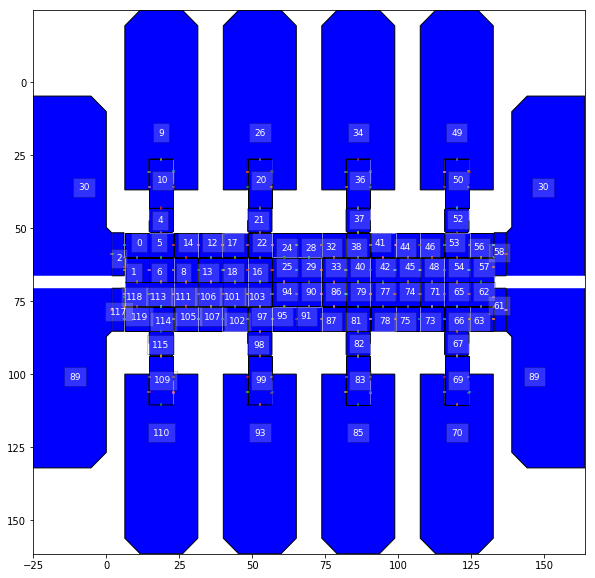

In [6]:
# Draw detected neighbours.
draw(df_shapes); pass

# Assign direction labels (i.e., `left`, `right`, `up`, `down`) to neighbours

In [7]:
def get_channel_neighbours(svg_source):
    '''
    Parameters
    ----------
    svg_source : str or file-like or pandas.DataFrame
        File path, URI, or file-like object for SVG device file.
        
        If specified as ``pandas.DataFrame``, assume argument is in format
        returned by :func:`svg_model.svg_shapes_to_df`.
    
    Returns
    -------
    pandas.Series
        
    '''
    if not isinstance(svg_source, pd.DataFrame):
        df_shapes = svg_model.svg_shapes_to_df(svg_source)
    else:
        df_shapes = svg_source
    df_segments = get_segments(df_shapes)
    df_intersections = get_all_intersections(df_shapes)
    
    df_neighbours = (df_intersections.reset_index([2, 3])
                     .join(df_segments, lsuffix='_neighbour'))
    df_neighbours.reset_index('id', inplace=True)
    df_neighbours.drop_duplicates(['id', 'id_neighbour'], inplace=True)
    df_neighbours.insert(0, 'direction', None)

    # Assign direction labels
    vertical = df_neighbours.x_normal.abs() < df_neighbours.y_normal.abs()
    df_neighbours.loc[vertical & (df_neighbours.y_normal < 0),
                      'direction'] = 'up'
    df_neighbours.loc[vertical & (df_neighbours.y_normal > 0),
                      'direction'] = 'down'
    df_neighbours.loc[~vertical & (df_neighbours.x_normal < 0),
                      'direction'] = 'left'
    df_neighbours.loc[~vertical & (df_neighbours.x_normal > 0),
                      'direction'] = 'right'
    df_neighbours.insert(0, 'normal_magnitude',
                           df_neighbours[['x_normal', 'y_normal']].abs()
                           .max(axis=1))

    df_neighbours.sort_values(['id', 'direction', 'normal_magnitude'],
                                inplace=True, ascending=False)
    # If multiple neighbours match a direction, only keep the first match.
    df_neighbours.drop_duplicates(['id', 'direction'], inplace=True)

    electrode_channels = (df_shapes.drop_duplicates(['id', 'data-channels'])
                          .set_index('id')['data-channels'].map(int))
    channel_electrodes = pd.Series(electrode_channels.index,
                                   index=electrode_channels.values)
    df_neighbours.insert(0, 'channel',
                         electrode_channels.loc[df_neighbours['id']].values)
    df_neighbours.insert(0, 'channel_neighbour',
                         electrode_channels.loc[df_neighbours['id_neighbour']]
                         .values)
    df_neighbours.set_index(['channel', 'direction'], inplace=True)
    df_neighbours.sort_index(inplace=True)

    directions = ['up', 'down', 'left', 'right']
    channel_neighbours = (df_neighbours['channel_neighbour']
                          .loc[[i for c in range(120)
                                for i in zip(it.cycle([c]), directions)]])
    return channel_neighbours

In [8]:
channel_neighbours = get_channel_neighbours(df_shapes)

## Export channel neighbours as `uint8` array

 - One row per channel
 - Each row contains channel numbers for the following neighbour directions:
   `[ up, down, left, right ]`
 - If a channel has no neighbour in a direction, the corresponding neighbour
   channel number is set to -1 (255 as a `uint8`).

In [9]:
channel_neighbours.fillna(-1).astype('uint8').head(16)

channel  direction
0        up           255
         down           1
         left           2
         right          5
1        up             0
         down         118
         left           2
         right          6
2        up           255
         down         255
         left          30
         right          1
3        up           255
         down         255
         left         255
         right        255
Name: channel_neighbour, dtype: uint8